<a href="https://colab.research.google.com/github/AjeetSingh02/Notebooks/blob/master/Deepa_DL_Assignment_1_GCN_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle data download

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ajeetsingh02","key":"d3428a1ac5badb4aa07463f5e936fb2f"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
# Make directory named kaggle and copy kaggle.json file there.
! cp kaggle.json ~/.kaggle/

In [6]:
# Change the permissions of the file
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle competitions download -c ieee-fraud-detection

 96% 113M/118M [00:01<00:00, 106MB/s]  
100% 118M/118M [00:01<00:00, 91.4MB/s]


In [8]:
! unzip /content/ieee-fraud-detection.zip

Archive:  /content/ieee-fraud-detection.zip
  inflating: sample_submission.csv   
  inflating: test_identity.csv       
  inflating: test_transaction.csv    
  inflating: train_identity.csv      
  inflating: train_transaction.csv   


# imports

In [ ]:
%%capture
! pip install dgl

In [10]:
# import pytorch and set dgl backend to pytorch
import os
os.environ['DGLBACKEND'] = 'pytorch'

In [11]:
import numpy as np
import pandas as pd
from time import time

import torch
import torch.nn  as nn
import torch.nn.functional as F

import dgl
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Data Read

In [12]:
transactions_df = pd.read_csv('/content/train_transaction.csv')
num_transactions = transactions_df.shape[0]
print("Number of transactions: ", num_transactions)
print(f"Proportion of fraudulent transaction: {transactions_df.isFraud.value_counts(normalize=True)[1]:.4f}")

Number of transactions:  590540
Proportion of fraudulent transaction: 0.0350


In [13]:
identity_df = pd.read_csv('/content/train_identity.csv')
print("Number of transaction with ID data: ", identity_df.shape[0])
print('-'*40)
print("Dataframe head:")
display(transactions_df.head())
display(identity_df.head())

Number of transaction with ID data:  144233
----------------------------------------
Dataframe head:


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [14]:
# user set the ratio
TRAIN_VAL_RATIO = 0.75

# determine number of training records
n_train = int(transactions_df.shape[0]*TRAIN_VAL_RATIO)

# train/val split : split by time, training set preceeds val set.
train_ids = transactions_df.TransactionID[:n_train]
val_ids = transactions_df.TransactionID[n_train:]

In [15]:
# get id columns from transactions_df
id_cols = ['card1','card2','card3','card4','card5','card6','ProductCD','addr1','addr2','P_emaildomain','R_emaildomain']

# get categorical columns for node features
cat_cols = ['M1','M2','M3','M4','M5','M6','M7','M8','M9']

# get features and labels
transactions_non_features = ['isFraud','TransactionDT'] + id_cols
features_cols = [col for col in transactions_df.columns if col not in transactions_non_features]

# create df for transaction node features
features_df = pd.get_dummies(transactions_df[features_cols], columns=cat_cols).fillna(0)

# take log of transaction amount
features_df['TransactionAmt'] = features_df['TransactionAmt'].apply(np.log10)

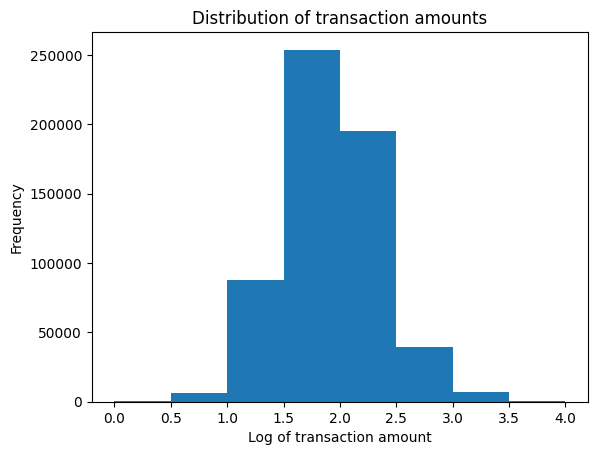

In [16]:
# show new distribution
features_df['TransactionAmt'].plot(kind='hist', bins=[0,0.5,1,1.5,2,2.5,3,3.5,4])
plt.title('Distribution of transaction amounts')
plt.xlabel('Log of transaction amount')
plt.show()

In [17]:
# create a df for the labels
labels_df = transactions_df[['TransactionID','isFraud']]

# create a list of all node types except TransactionID
node_types = id_cols + list(identity_df.columns)
node_types.remove('TransactionID')

# join the dfs to get a table with all ID data
full_identity_df = identity_df.merge(transactions_df[id_cols+['TransactionID']], on='TransactionID', how='right')

In [19]:
full_identity_df.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,card2,card3,card4,card5,card6,ProductCD,addr1,addr2,P_emaildomain,R_emaildomain
0,2987000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,150.0,discover,142.0,credit,W,315.0,87.0,NaN,NaN
1,2987001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,404.0,150.0,mastercard,102.0,credit,W,325.0,87.0,gmail.com,NaN
2,2987002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,490.0,150.0,visa,166.0,debit,W,330.0,87.0,outlook.com,NaN
3,2987003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,567.0,150.0,mastercard,117.0,debit,W,476.0,87.0,yahoo.com,NaN
4,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,514.0,150.0,mastercard,102.0,credit,H,420.0,87.0,gmail.com,NaN


In [ ]:
# create a dictionary of df that will determine the edges in the graph
edge_dfs = {}
for ntype  in node_types:
    edge_dfs[ntype] = full_identity_df[['TransactionID', ntype]].dropna()

In [24]:
edge_dfs["card1"]

,TransactionID,card1
0,2987000,13926
1,2987001,2755
2,2987002,4663
3,2987003,18132
4,2987004,4497
...,...,...
590535,3577535,6550
590536,3577536,10444
590537,3577537,12037
590538,3577538,7826


In [20]:
# initialize the dictionary to store each ID to dgl node index dictionary
id_to_node = {}

# First get dgl indices for TransactionID/target nodes
id_to_node['target'] = dict([(v,k) for k,v in dict(transactions_df['TransactionID']).items()])

# Then cycle through the other ID types and add those to the list (dict)
for ntype in node_types:
    new_nodes_ids = edge_dfs[ntype][ntype].unique()
    new_nodes_dgl = np.arange(len(new_nodes_ids)+1)
    id_to_node[ntype] = { a:b for a,b in zip(new_nodes_ids, new_nodes_dgl)}

In [22]:
id_to_node['card4']

{'discover': 0, 'mastercard': 1, 'visa': 2, 'american express': 3}

In [25]:
# instantiate the edge list dictionary
edgelists = {}
num_nodes_dict = {}

for ntype in node_types:
    # prepare each edge type triple and its reverse
    edge_type = ('target','target<>'+ntype,ntype)
    rev_edge_type = (ntype, ntype+'<>target','target')

    # get list of initial nodes and destination nodes
    source_nodes = edge_dfs[ntype]['TransactionID'].apply(lambda a : id_to_node['target'][a]).to_numpy()
    destination_nodes = edge_dfs[ntype][ntype].apply(lambda a : id_to_node[ntype][a]).to_numpy()

    # add to dict
    edgelists[edge_type] = ( source_nodes, destination_nodes )
    edgelists[rev_edge_type] = (destination_nodes, source_nodes)

    # get number of nodes of this type
    num_nodes_dict[ntype] = len(np.unique(destination_nodes))

# add self-loops for target nodes
source_nodes = edge_dfs[ntype]['TransactionID'].apply(lambda a : id_to_node['target'][a]).to_numpy()
edgelists[('target','target<>target','target')] = (source_nodes,source_nodes)
num_nodes_dict['target'] = num_transactions

# create pytorch tensor consisting of features for each node
feature_tensor = torch.from_numpy(features_df.drop('TransactionID', axis=1).to_numpy())

# add feature data to graph
g.nodes['target'].data['features'] = feature_tensor


In [31]:
len(edgelists[('target', 'target<>card1', 'card1')][1])

590540

In [32]:
# create the graph
g = dgl.heterograph(edgelists, num_nodes_dict)

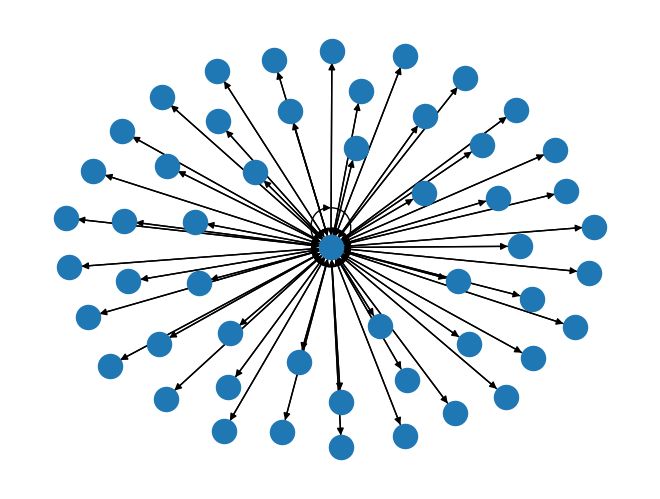

In [33]:
meta = g.metagraph()
nx.draw(meta)

In [34]:
# create pytorch tensor consisting of features for each node
feature_tensor = torch.from_numpy(features_df.drop('TransactionID', axis=1).to_numpy())

# add feature data to graph
g.nodes['target'].data['features'] = feature_tensor

In [35]:
# sanity check
# for random target node, compare expected features with the feature of the node
trial = 1515

# data from the table
orig_feat = torch.from_numpy(features_df.iloc[trial,1:].to_numpy())
# data from the graph
graph_feat = g.ndata['features']['target'][trial]

assert max(orig_feat - graph_feat) == 0
print('Feature vectors match. Check is good!')

Feature vectors match. Check is good!
